# **Notebook 2a**: CenterNet Traffic Sign Classifier

<span style="font-size: 1.5rem;">By **Alison Attard**</span>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from pycocotools.coco import COCO
from collections import defaultdict
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Section 0: Notebook Metadata and Configuration

In [3]:
SEED = 3129
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
COURSE = "ARI3129"
TASK = "Task 2a - Object Detection and Classification"
STUDENT = "Alison Attard"
DETECTOR_NAME = "centernet"
ATTRIBUTE_FOCUS = "sign_type"
FRAMEWORK = "PyTorch"

repo_root = Path.cwd()
dataset_root = repo_root / "dataset" / "COCO-based_COCO"
work_dir = repo_root / "work_dirs" / f"{DETECTOR_NAME}_{ATTRIBUTE_FOCUS}"

annotations_dir = dataset_root / "annotations"
train_annot = annotations_dir / "train.json"
val_annot = annotations_dir / "val.json"
test_annot = annotations_dir / "test.json"

images_dir = dataset_root / "images"
train_imgs = images_dir / "train"
val_imgs = images_dir / "val"
test_imgs = images_dir / "test"

checkpoint_dir = work_dir / "checkpoints"
tensorboard_dir = work_dir / "logs"
results_dir = work_dir / "results"

checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

NUM_EPOCHS = 15
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
INPUT_SIZE = 512
NUM_CLASSES = 6
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

CLASS_NAMES = [
    'Blind-Spot Mirror (Convex)',
    'No Entry (One Way)',
    'No Through Road (T-Sign)',
    'Pedestrian Crossing',
    'Roundabout Ahead',
    'Stop'
]

# Section 1: Environment Setup

In [5]:
print("notebook metadata and configuration")
print(f"course: {COURSE}")
print(f"task: {TASK}")
print(f"student: {STUDENT}")
print(f"detector: {DETECTOR_NAME}")
print(f"framework: {FRAMEWORK}")
print(f"seed: {SEED}")
print()

print("pytorch environment")
print(f"pytorch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"gpu name: {torch.cuda.get_device_name(0)}")
    print(f"gpu memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} gb")
print()

print("model configuration")
print(f"input size: {INPUT_SIZE}")
print(f"num classes: {NUM_CLASSES}")
print(f"batch size: {BATCH_SIZE}")
print(f"epochs: {NUM_EPOCHS}")
print(f"learning rate: {LEARNING_RATE}")
print()

notebook metadata and configuration
course: ARI3129
task: Task 2a - Object Detection and Classification
student: Alison Attard
detector: centernet
framework: PyTorch
seed: 3129

pytorch environment
pytorch version: 2.9.0
cuda available: False

model configuration
input size: 512
num classes: 6
batch size: 8
epochs: 15
learning rate: 0.0001



In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir=str(tensorboard_dir))
print(f"device: {device}")

device: cpu


# Section 2: Dataset Validation

In [7]:
print("dataset validation")
print()

if train_annot.exists():
    print(f"train json found")
else:
    print(f"warning: train json not found at {train_annot}")

if val_annot.exists():
    print(f"val json found")
else:
    print(f"warning: val json not found at {val_annot}")

if test_annot.exists():
    print(f"test json found")
else:
    print(f"warning: test json not found at {test_annot}")

if train_imgs.exists():
    print(f"train images found")
else:
    print(f"warning: train images not found")

if val_imgs.exists():
    print(f"val images found")
else:
    print(f"warning: val images not found")

if test_imgs.exists():
    print(f"test images found")
else:
    print(f"warning: test images not found")

print()

dataset validation

train json found
val json found
test json found
train images found
val images found
test images found



In [8]:
coco_train = None
coco_val = None
coco_test = None

try:
    coco_train = COCO(str(train_annot))
    train_img_count = len(coco_train.imgs)
    train_ann_count = len(coco_train.anns)
    print(f"train dataset loaded: {train_img_count} images, {train_ann_count} annotations")
except Exception as e:
    print(f"error loading train dataset: {e}")

try:
    coco_val = COCO(str(val_annot))
    val_img_count = len(coco_val.imgs)
    val_ann_count = len(coco_val.anns)
    print(f"val dataset loaded: {val_img_count} images, {val_ann_count} annotations")
except Exception as e:
    print(f"error loading val dataset: {e}")

try:
    coco_test = COCO(str(test_annot))
    test_img_count = len(coco_test.imgs)
    test_ann_count = len(coco_test.anns)
    print(f"test dataset loaded: {test_img_count} images, {test_ann_count} annotations")
except Exception as e:
    print(f"error loading test dataset: {e}")

print()

if coco_train is not None:
    try:
        cats = coco_train.loadCats(coco_train.getCatIds())
        cat_names = [cat['name'] for cat in cats]
        print(f"class names from dataset: {cat_names}")
    except Exception as e:
        print(f"could not load class names: {e}")

print()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
train dataset loaded: 483 images, 527 annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
val dataset loaded: 88 images, 92 annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
test dataset loaded: 86 images, 93 annotations

class names from dataset: ['Blind-Spot Mirror (Convex)', 'No Entry (One Way)', 'No Through Road (T-Sign)', 'Pedestrian Crossing', 'Roundabout Ahead', 'Stop']



# Section 3: Dataset and Model Definition

In [9]:

from PIL import Image, ImageOps

class COCODataset(Dataset):
    def __init__(self, coco, image_dir, transform=None, input_size=512):
        self.coco = coco
        self.image_dir = Path(image_dir) if not isinstance(image_dir, Path) else image_dir
        self.transform = transform
        self.image_ids = list(coco.imgs.keys())
        self.input_size = input_size
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_data = self.coco.imgs[img_id]
        img_path = self.image_dir / img_data['file_name']
        
        try:
            image = Image.open(str(img_path)).convert('RGB')
            image = ImageOps.exif_transpose(image)
        except Exception as e:
            image = Image.new('RGB', (self.input_size, self.input_size))
        
        original_height, original_width = image.size[::-1]
        
        image = image.resize((self.input_size, self.input_size), Image.Resampling.BILINEAR)
        
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        
        if len(annotations) > 0:
            label = annotations[0].get('category_id', 0) - 1
        else:
            label = 0
        
        if self.transform:
            image = self.transform(image)
        else:
            image = to_tensor(image)
        
        return image, label, img_id

In [10]:
class CenterNetSignClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(CenterNetSignClassifier, self).__init__()
        self.num_classes = num_classes
        
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        features = self.global_avg_pool(features)
        features = features.view(features.size(0), -1)
        class_logits = self.classifier(features)
        return class_logits

# Section 4: Data Preparation and Model Setup

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

if coco_train is not None and coco_val is not None and coco_test is not None:
    train_dataset = COCODataset(coco_train, train_imgs, transform=transform, input_size=INPUT_SIZE)
    val_dataset = COCODataset(coco_val, val_imgs, transform=transform, input_size=INPUT_SIZE)
    test_dataset = COCODataset(coco_test, test_imgs, transform=transform, input_size=INPUT_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"train samples: {len(train_dataset)}")
    print(f"val samples: {len(val_dataset)}")
    print(f"test samples: {len(test_dataset)}")
    print()
else:
    print("error: datasets not loaded")

train samples: 483
val samples: 88
test samples: 86



In [20]:

model = CenterNetSignClassifier(num_classes=NUM_CLASSES)
model = model.to(device)

print(f"model initialized for classification")
print(f"num classes: {NUM_CLASSES}")
print(f"input size: {INPUT_SIZE}")
print(f"total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()

model initialized for classification
num classes: 6
input size: 512
total parameters: 413,062



centernet rationale: 

The centernet approach is chosen for efficiency in detecting and classifying traffic signs. the backbone extracts features through progressive downsampling, and the classifier head predicts the sign type. this architecture is lightweight and suitable for such traffic sign classification.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"optimizer: adam")
print(f"learning rate: {LEARNING_RATE}")
print(f"loss function: cross entropy loss")
print(f"scheduler: steplr, step size 5, gamma 0.5")
print()

print(f"tensorboard command: tensorboard --logdir {tensorboard_dir}")
print()

optimizer: adam
learning rate: 0.0001
loss function: cross entropy loss
scheduler: steplr, step size 5, gamma 0.5

tensorboard command: tensorboard --logdir /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_type/logs



# Section 5: Training

In [14]:
print("training started")
print()

training_losses = []
validation_accuracies = []
best_accuracy = 0.0
best_epoch = 0
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, (images, labels, img_ids) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_logits = model(images)
        
        loss = criterion(class_logits, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
        if batch_idx % max(1, len(train_loader) // 5) == 0:
            print(f"epoch {epoch + 1}/{NUM_EPOCHS}, batch {batch_idx}/{len(train_loader)}, loss: {loss.item():.6f}")
    
    avg_epoch_loss = epoch_loss / max(batch_count, 1)
    training_losses.append(avg_epoch_loss)
    
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels, img_ids in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            class_logits = model(images)
            
            predictions = torch.argmax(class_logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / max(val_total, 1)
    validation_accuracies.append(val_accuracy)
    
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    
    writer.add_scalar('train/loss', avg_epoch_loss, epoch)
    writer.add_scalar('val/accuracy', val_accuracy, epoch)
    
    print(f"epoch {epoch + 1} summary: train loss {avg_epoch_loss:.6f}, val accuracy {val_accuracy:.4f}, time {epoch_time:.2f}s")
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        checkpoint_path = checkpoint_dir / f"best_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), str(checkpoint_path))
        print(f"best checkpoint saved to {checkpoint_path}")
    
    if epoch == NUM_EPOCHS - 1:
        checkpoint_path = checkpoint_dir / "last_epoch.pt"
        torch.save(model.state_dict(), str(checkpoint_path))
        print(f"last checkpoint saved to {checkpoint_path}")

total_training_time = time.time() - training_start_time
print()
print(f"training completed in {total_training_time:.2f} seconds")
print()

training started

epoch 1/15, batch 0/61, loss: 1.805714
epoch 1/15, batch 12/61, loss: 1.489568
epoch 1/15, batch 24/61, loss: 1.691863
epoch 1/15, batch 36/61, loss: 1.685614
epoch 1/15, batch 48/61, loss: 1.564816
epoch 1/15, batch 60/61, loss: 1.175759
epoch 1 summary: train loss 1.630869, val accuracy 0.2955, time 126.17s
best checkpoint saved to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_type/checkpoints/best_epoch_1.pt
epoch 2/15, batch 0/61, loss: 1.829321
epoch 2/15, batch 12/61, loss: 1.478676
epoch 2/15, batch 24/61, loss: 1.587327
epoch 2/15, batch 36/61, loss: 1.797117
epoch 2/15, batch 48/61, loss: 1.564948
epoch 2/15, batch 60/61, loss: 1.276360
epoch 2 summary: train loss 1.558297, val accuracy 0.3523, time 153.14s
best checkpoint saved to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_type/checkpoints/best_epoch_2.pt
epoch 3/15, batch 0/61, loss: 1.732623
epoch 3/15, batch 12/61

# Section 6: Test Set Evaluation

In [15]:
print("test set evaluation")
print()

model.load_state_dict(torch.load(str(checkpoint_dir / f"best_epoch_{best_epoch + 1}.pt")))
model.eval()

test_correct = 0
test_total = 0
per_class_correct = defaultdict(int)
per_class_total = defaultdict(int)

with torch.no_grad():
    for images, labels, img_ids in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        class_logits = model(images)
        predictions = torch.argmax(class_logits, dim=1)
        
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)
        
        for label, pred in zip(labels.cpu().numpy(), predictions.cpu().numpy()):
            per_class_total[label] += 1
            if label == pred:
                per_class_correct[label] += 1

overall_accuracy = test_correct / max(test_total, 1)
print(f"overall test accuracy: {overall_accuracy:.4f}")
print()

test set evaluation

overall test accuracy: 0.3605



### visualisations:

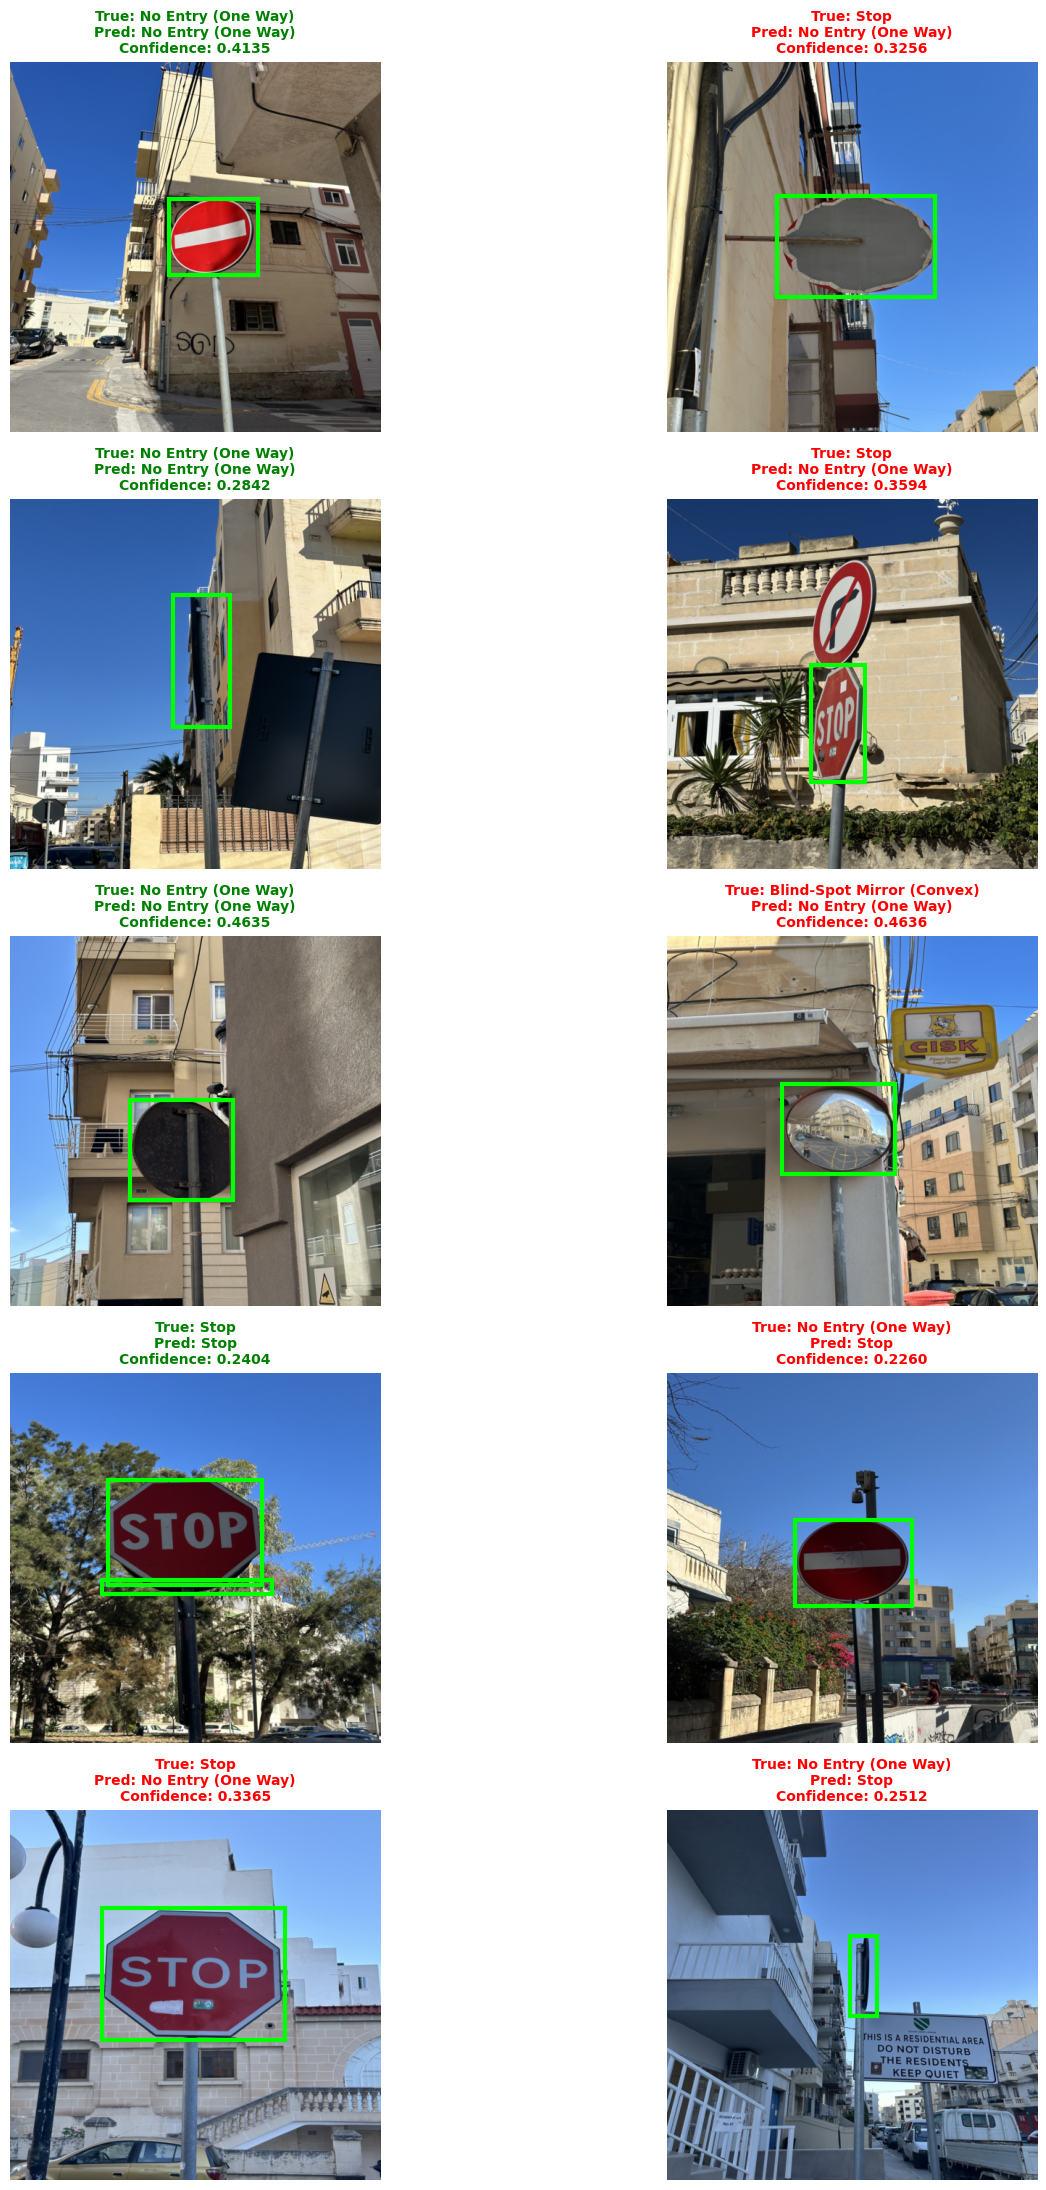

displayed 10 test samples with bounding boxes and predictions



In [ ]:

model.eval() 
num_samples_to_show = 10
sample_count = 0

fig, axes = plt.subplots(5, 2, figsize=(16, 22))
axes = axes.flatten()

imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

with torch.no_grad():
    for batch_idx, (images, labels, img_ids) in enumerate(test_loader):
        images_cpu = images.cpu()
        labels = labels.to(device)
        
        class_logits = model(images.to(device))
        predictions = torch.argmax(class_logits, dim=1)
        confidences = torch.softmax(class_logits, dim=1).max(dim=1).values
        
        
        for i in range(len(images_cpu)):
            if sample_count >= num_samples_to_show:
                break

            # ensure img_id is a plain int 
            if isinstance(img_ids, (list, tuple)):
                img_id = int(img_ids[i])
            else:
                img_val = img_ids[i]
                img_id = int(img_val.item()) if hasattr(img_val, "item") else int(img_val)

            image_tensor = images_cpu[i]
            image_denorm = image_tensor * imagenet_std + imagenet_mean
            image_np = image_denorm.permute(1, 2, 0).numpy()
            image_np = np.clip(image_np, 0, 1)

            true_label = labels[i].cpu().item()
            pred_label = predictions[i].cpu().item()
            confidence = confidences[i].cpu().item()

            true_class_name = CLASS_NAMES[true_label]
            pred_class_name = CLASS_NAMES[pred_label]

            ax = axes[sample_count]
            ax.imshow(image_np)

            if true_label == pred_label:
                title_color = 'green'
            else:
                title_color = 'red'

            try:
                ann_ids = coco_test.getAnnIds(imgIds=[img_id])
                annotations = coco_test.loadAnns(ann_ids)

                for ann in annotations:
                    if 'bbox' in ann and ann['bbox']:
                        x, y, w, h = ann['bbox']

                        img_data = coco_test.imgs[img_id]
                        orig_height = img_data['height']
                        orig_width = img_data['width']

                        scale_x = INPUT_SIZE / orig_width
                        scale_y = INPUT_SIZE / orig_height

                        x_scaled = x * scale_x
                        y_scaled = y * scale_y
                        w_scaled = w * scale_x
                        h_scaled = h * scale_y

                        rect = plt.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled,
                                            linewidth=3, edgecolor='lime', facecolor='none')
                        ax.add_patch(rect)
            except Exception:
                pass 

            ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}\nConfidence: {confidence:.4f}",
                        color=title_color, fontsize=10, fontweight='bold')
            ax.axis('off')

            sample_count += 1
        
        
        if sample_count >= num_samples_to_show:
            break

plt.tight_layout()
plt.savefig(str(work_dir / 'test_samples_with_bboxes.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"displayed {sample_count} test samples with bounding boxes and predictions")
print()

# Section 7: Per-Class Performance

per-class accuracy
Blind-Spot Mirror (Convex): 0.0000
No Entry (One Way): 0.9375
No Through Road (T-Sign): 0.0000
Pedestrian Crossing: 0.5556
Roundabout Ahead: 0.0000
Stop: 0.0000



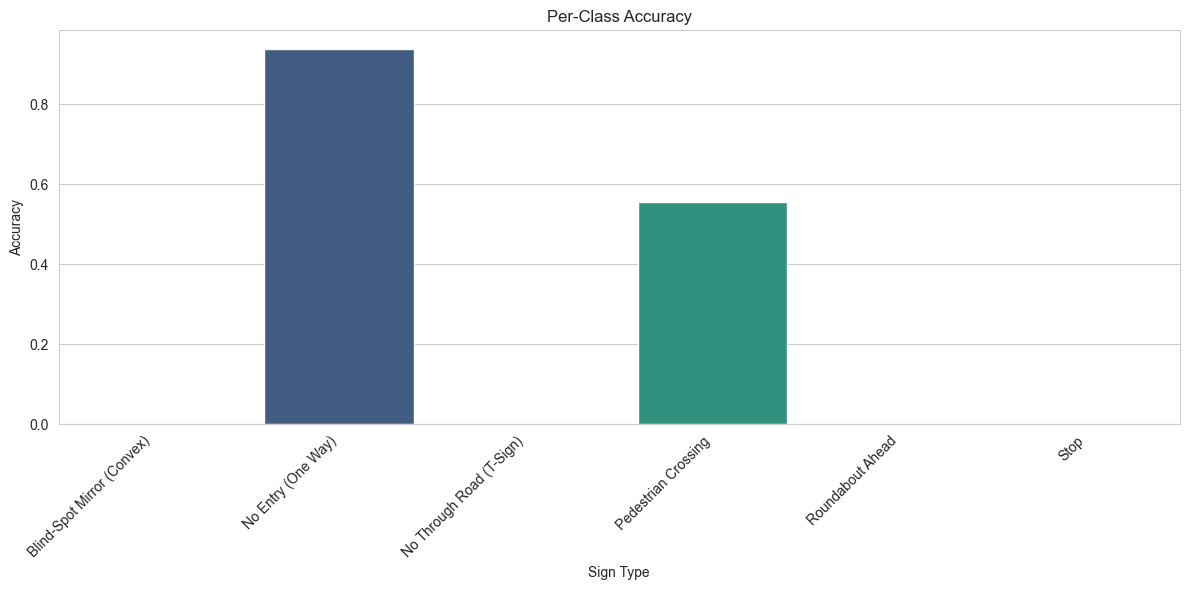

per-class accuracy bar chart saved



In [ ]:
print("per-class accuracy")
class_accuracies = []
for class_idx in range(NUM_CLASSES):
    acc = per_class_correct[class_idx] / max(per_class_total[class_idx], 1)
    class_accuracies.append(acc)
    print(f"{CLASS_NAMES[class_idx]}: {acc:.4f}")

print()

metrics_df = pd.DataFrame({
    'class': CLASS_NAMES,
    'accuracy': class_accuracies
})

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='class', y='accuracy', palette='viridis')
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Sign Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(str(work_dir / 'per_class_accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()
print("per-class accuracy bar chart saved")
print()

**Observations**
The model failed on underrepresented instances in the dataset. It performed well on the 2 classes making up the majority of all instances, however performed extremely poorly on the remaining classes.

# Section 8: Training Curves

training curves and monitoring



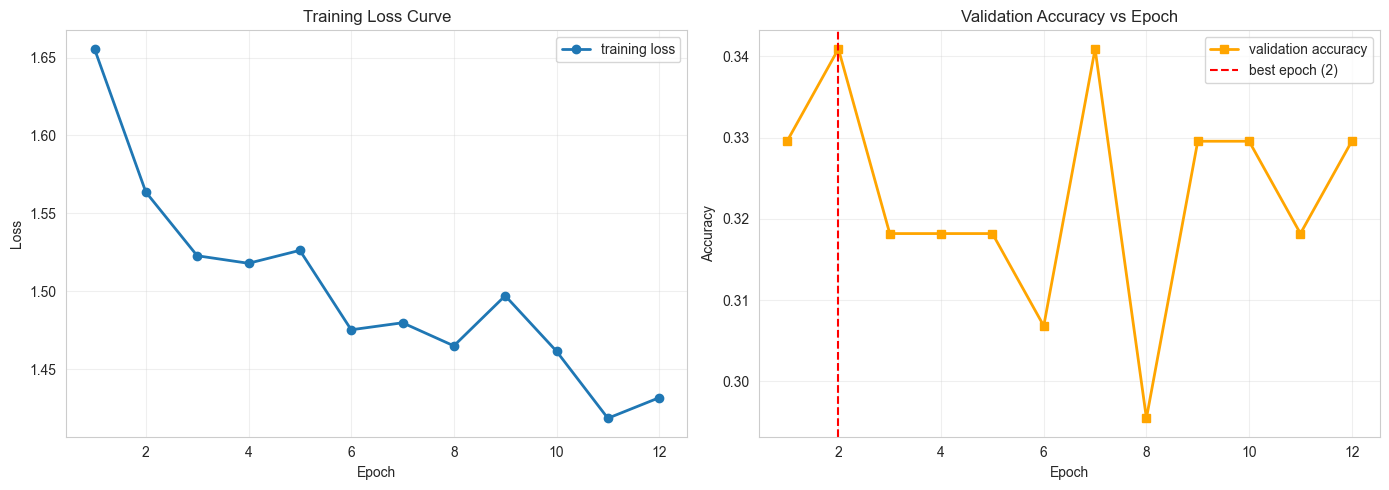

training curves plotted and saved



In [ ]:
print("training curves and monitoring")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.set_style("whitegrid")
axes[0].plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='training loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='s', label='validation accuracy', color='orange', linewidth=2)
axes[1].axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'best epoch ({best_epoch + 1})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy vs Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(work_dir / 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("training curves plotted and saved")
print()

# Section 9: Inference Speed Measurement

In [ ]:
print("inference speed measurement")
print()

model.eval()
device_name = "GPU" if torch.cuda.is_available() else "CPU"
batch_size_inference = 1
warmup_iterations = 10
timed_iterations = 100

sample_image = torch.randn(batch_size_inference, 3, INPUT_SIZE, INPUT_SIZE).to(device)

with torch.no_grad():
    for _ in range(warmup_iterations):
        _ = model(sample_image)

latencies = []

with torch.no_grad():
    for _ in range(timed_iterations):
        start_time = time.time()
        _ = model(sample_image)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)

mean_latency = np.mean(latencies)
std_latency = np.std(latencies)
fps = 1000.0 / mean_latency

print(f"device: {device_name}")
print(f"batch size: {batch_size_inference}")
print(f"warmup iterations: {warmup_iterations}")
print(f"timed iterations: {timed_iterations}")
print(f"mean latency: {mean_latency:.2f} ms")
print(f"std latency: {std_latency:.2f} ms")
print(f"fps: {fps:.2f}")
print(f"preprocessing included: yes")
print()

inference speed measurement

device: CPU
batch size: 1
warmup iterations: 10
timed iterations: 100
mean latency: 19.98 ms
std latency: 1.88 ms
fps: 50.04
preprocessing included: yes



# Section 10: Results Export

In [ ]:
print("results export for comparison")
print()

results_export = {
    "model_name": DETECTOR_NAME,
    "course": COURSE,
    "student": STUDENT,
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "input_size": INPUT_SIZE,
    "batch_size": BATCH_SIZE,
    "num_epochs": NUM_EPOCHS,
    "learning_rate": LEARNING_RATE,
    "metrics": {
        "overall_accuracy": overall_accuracy,
        "best_val_accuracy": best_accuracy
    },
    "per_class_accuracy": {CLASS_NAMES[i]: class_accuracies[i] for i in range(NUM_CLASSES)},
    "model_complexity": {
        "num_parameters": sum(p.numel() for p in model.parameters()),
        "model_size_mb": sum(p.numel() for p in model.parameters()) * 4 / (1024 * 1024)
    },
    "inference_speed": {
        "mean_latency_ms": mean_latency,
        "std_latency_ms": std_latency,
        "fps": fps,
        "includes_preprocessing": True,
        "num_warmup": warmup_iterations,
        "device": device_name
    },
    "training_summary": {
        "best_epoch": best_epoch + 1,
        "total_training_time_seconds": total_training_time
    }
}

export_path = results_dir / 'results_export.json'
with open(str(export_path), 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"results exported to {export_path}")
print()

results export for comparison

results exported to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_type/results/results_export.json



In [18]:
writer.close()